# Chile's Significant Earthquake Events

## 1.  Importing and Cleaning Data

First use the packages `requests` and `bs4` to import the webpage with earthquake data. As we gonna see below, the table of this page continues in multiple pages. We need to extract the number of pages to make a full extraction of all available events.

In [135]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# URL to be imported
url = 'http://evtdb.csn.uchile.cl'
# Open a URL request 
r = requests.get(url)
# Get HTML text
html_doc = r.text
# Create a BeautifulSoup object to extract HTML data using Tags
soup = BeautifulSoup(html_doc)

Those are the BS4 elements of the HTML page:

In [126]:
[type(item) for item in list(soup.children)]

[bs4.element.Doctype, bs4.element.Tag]

In [217]:
numbers = []
for item in soup.find_all('li'):
    if str(item.string).find('Página') != -1:
        for word in str(item.string).split():
            if word.isdigit():
                numbers.append(int(word))
                
print(numbers[-1])

136


This method works, but there is a more direct way, in which we do not even need to extract the page number! We just need to

In [226]:
df = pd.DataFrame()
page = 1
while requests.get(url+"/?page="+str(page)).status_code == 200:
    r = requests.get(url+"/?page="+str(page))
    soup = BeautifulSoup(r.text)
    df = df.append(pd.read_html(str(soup.find_all(class_="paleblue sortable")))[0], ignore_index=True)
    page += 1
else:
    print("Failed in page " + str(page) + " due to HTTP code" + str(requests.get(url+"/?page="+str(page)).status_code))

Failed in page137due to500


In [240]:
df.head()

,Fecha (UTC),Latitud [º],Longitud [º],Profundidad [km],Magnitud [*]
0,2021-11-24 23:14:32,-20.52,-69.18,98,4.9
1,2021-11-18 14:10:05,-20.93,-68.87,127,4.5
2,2021-11-13 00:16:58,-22.14,-70.44,30,3.6
3,2021-11-04 04:18:22,-30.31,-71.22,52,5.2
4,2021-11-03 03:17:47,-32.66,-70.11,113,5.8


In [243]:
df['Fecha (UTC)'] = df['Fecha (UTC)'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702 entries, 0 to 2701
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha (UTC)       2702 non-null   datetime64[ns]
 1   Latitud [º]       2702 non-null   float64       
 2   Longitud [º]      2702 non-null   float64       
 3   Profundidad [km]  2702 non-null   int64         
 4   Magnitud [*]      2702 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 105.7 KB


In [244]:
df.isna().sum()

Fecha (UTC)         0
Latitud [º]         0
Longitud [º]        0
Profundidad [km]    0
Magnitud [*]        0
dtype: int64

In [245]:
cols = ['date_utc', 'latitude_deg', 'longitude_deg', 'depth_km', 'magnitude'] 
df.columns = cols
df.head()

,date_utc,latitude_deg,longitude_deg,depth_km,magnitude
0,2021-11-24 23:14:32,-20.52,-69.18,98,4.9
1,2021-11-18 14:10:05,-20.93,-68.87,127,4.5
2,2021-11-13 00:16:58,-22.14,-70.44,30,3.6
3,2021-11-04 04:18:22,-30.31,-71.22,52,5.2
4,2021-11-03 03:17:47,-32.66,-70.11,113,5.8


###  Exploratory Data Analysis

Our table contains sismic events ordered by datetime, location, depth and magnitude. The questions we want to address in this notebook are

* How are the events distributed in space and time?
* What's the frequency of events as a function of their magnitude?

In [269]:
df.describe()
plt.show()

,latitude_deg,longitude_deg,depth_km,magnitude
count,2702.000000,2702.000000,2702.000000,2702.000000
mean,-27.506077,-70.825862,60.570688,4.547668
std,5.879959,1.283901,38.800012,0.660332
min,-62.350000,-74.820000,2.000000,2.300000
25%,-31.590000,-71.590000,35.000000,4.100000
50%,-29.590000,-71.160000,48.000000,4.500000
75%,-21.110000,-70.060000,84.000000,4.900000
max,-11.070000,-58.390000,624.000000,8.400000


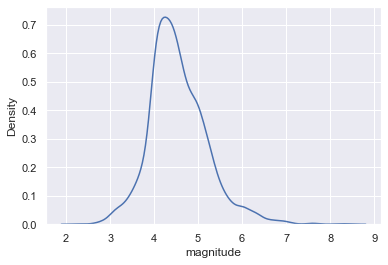

In [260]:
sns.kdeplot(x='magnitude', data=df)
plt.show()

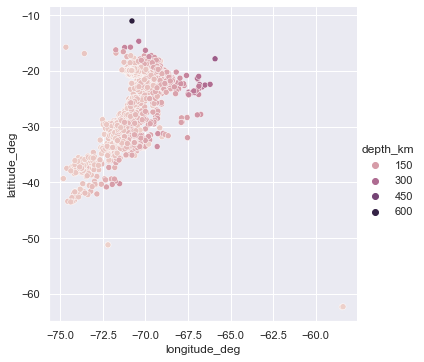

In [268]:
sns.relplot(x='longitude_deg', y= 'latitude_deg', hue='depth_km', data=df)
plt.show()

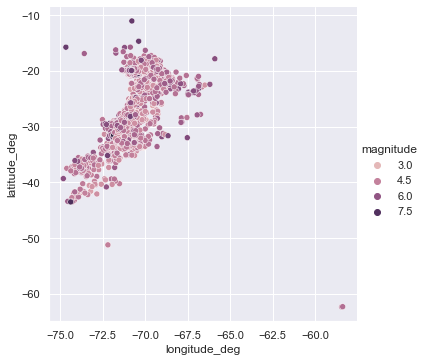

In [270]:
sns.relplot(x='longitude_deg', y= 'latitude_deg', hue='magnitude', data=df)
plt.show()

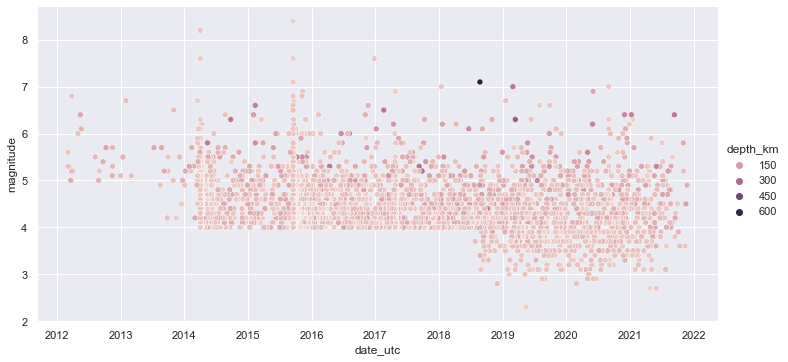

In [287]:
sns.relplot(x='date_utc', y='magnitude', hue='depth_km', data=df, kind='scatter', aspect=2)
plt.show()

## Next Steps

* Do a more detailed statistical analysis on the distribution of magnitudes.
* Check the Gutenber-Ritcher (Log(number of events per century) vs. magnitude) and Utsu-Omori laws (distribution of replicas with time).
* Can we find correlations between these events and other geophysical data like volcano eruptions?
* Explore other datasets with a larger quantity of events.
* Try to predict earthquakes from seismograph data.